In [1]:
from metrics.function_error import SquaredError
from models.linear import LeastSquaresModel
from models.zero_model import ZeroModel
from function_classes.linear import LinearRegression

from torch.distributions.normal import Normal
import torch

from torch import nn


from torch import normal

/opt/conda/envs/in-context-learning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m = Normal(torch.zeros((100, 100, 10)), torch.ones((100, 100 ,10))) #batch size, sequence_length, x_dim

error=SquaredError(function_class=LinearRegression(m))

evals=error.evaluate([LeastSquaresModel(), ZeroModel()])


print(evals[0].keys())

print(evals[1])



dict_keys(['accuracy_OLS_driver=None', 'std_OLS_driver=None', 'std_mean_OLS_driver=None', 'max_OLS_driver=None', 'min_OLS_driver=None', 'quantile_OLS_driver=None0.01', 'quantile_OLS_driver=None0.05', 'quantile_OLS_driver=None0.1', 'quantile_OLS_driver=None0.25', 'quantile_OLS_driver=None0.5', 'quantile_OLS_driver=None0.75', 'quantile_OLS_driver=None0.9', 'quantile_OLS_driver=None0.95', 'quantile_OLS_driver=None0.99', 'variance_estimate', 'mean_estimate', 'ppf', 'normal_confidence_levelOLS_driver=None0.01', 'bootstrap_confidence_levelOLS_driver=None0.01', 'normal_confidence_levelOLS_driver=None0.05', 'bootstrap_confidence_levelOLS_driver=None0.05', 'accuracy_zero_model', 'std_zero_model', 'std_mean_zero_model', 'max_zero_model', 'min_zero_model', 'quantile_zero_model0.01', 'quantile_zero_model0.05', 'quantile_zero_model0.1', 'quantile_zero_model0.25', 'quantile_zero_model0.5', 'quantile_zero_model0.75', 'quantile_zero_model0.9', 'quantile_zero_model0.95', 'quantile_zero_model0.99', 'nor

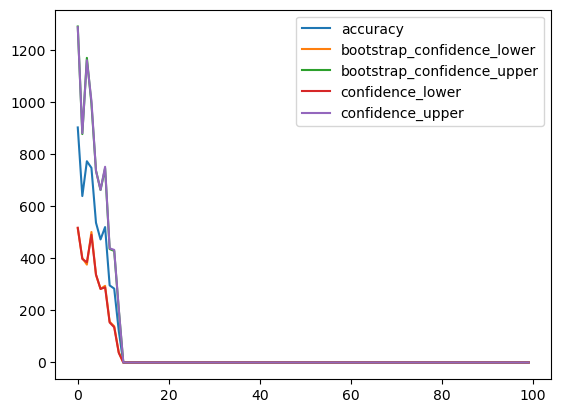

tensor([150.4683, 108.2673, 151.2006, 133.9688, 125.6389, 168.7376, 178.2841,
        121.1454, 121.5067, 202.9971, 146.9890, 130.6974, 161.7524, 102.3577,
        175.8341, 162.8624, 151.1871, 173.4103, 142.4011, 174.2257, 194.2388,
        143.1711, 175.2366, 325.4592, 159.1854, 177.7319, 134.3948, 183.4068,
        142.5586, 177.5110, 147.7713, 221.3635, 100.7414, 164.7516, 137.7633,
        110.1792, 142.8406, 176.4139, 157.9281, 180.4384, 155.3777, 178.7593,
        126.5375, 116.1392, 220.7678, 138.0286, 290.8393, 189.1326, 306.9035,
        181.2216, 237.8663, 325.1419, 143.2867, 160.5110, 165.5527, 149.9157,
        218.4234,  96.8948, 161.6807, 149.0677, 168.9085, 132.2926, 107.9915,
        159.0571, 147.3425, 248.8080, 137.9434, 118.2536,  98.4348, 158.7015,
        248.7077, 165.2413, 187.3819, 158.8537, 138.5329, 177.6722, 153.2666,
        181.3704, 136.8195, 220.7445, 237.3375, 140.3183, 156.4519, 151.8149,
        140.6464, 204.9223, 240.9151, 153.2730, 137.8486, 198.91

In [3]:
import matplotlib.pyplot as plt

plt.plot(evals[0]['accuracy_OLS_driver=None'],label="accuracy")
plt.plot(evals[0]["bootstrap_confidence_levelOLS_driver=None0.01"][0],label="bootstrap_confidence_lower")
plt.plot(evals[0]["bootstrap_confidence_levelOLS_driver=None0.01"][1],label="bootstrap_confidence_upper")
plt.plot(evals[0]["normal_confidence_levelOLS_driver=None0.01"][0],label="confidence_lower")
plt.plot(evals[0]["normal_confidence_levelOLS_driver=None0.01"][1],label="confidence_upper")

plt.legend()
plt.show()

#print(evals[0]["accuracy_OLS_driver=None"])
print(evals[0]["variance_estimate"])
print(evals[0]["mean_estimate"])
print(evals[0]["ppf"])

print(evals[0]["bootstrap_confidence_levelOLS_driver=None0.05"][0])
print(evals[0]["bootstrap_confidence_levelOLS_driver=None0.01"][1])


plt.show()